In [62]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [63]:
#### Preprocecing ###

In [64]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [65]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [66]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]
confirmed = confirmed.cummax()

In [67]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]
recovered = recovered.cummax()


In [68]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]
death = death.cummax()

In [69]:
### Data Preparation ###

In [70]:
country = 'Korea, South'
S0 = confirmed[country].values
R0 = recovered[country].values
D0 = death[country].values
P = 5000_0000
iter=10000

In [71]:
S0

array([    1,     1,     2,     2,     3,     4,     4,     4,     4,
          11,    12,    15,    15,    16,    19,    23,    24,    24,
          25,    27,    28,    28,    28,    28,    28,    29,    30,
          31,    31,   104,   204,   433,   602,   833,   977,  1261,
        1766,  2337,  3150,  3736,  4335,  5186,  5621,  6088,  6593,
        7041,  7314,  7478,  7513,  7755,  7869,  7979,  8086,  8162,
        8236,  8320,  8413,  8565,  8652,  8799,  8961,  8961,  9037,
        9137,  9241,  9332,  9478,  9583,  9661,  9786,  9887,  9976,
       10062, 10156, 10237, 10284, 10331, 10384, 10423, 10450])

In [72]:
data = {'T': S0.shape[0], 'P': P, 'S0': S0, 'R0': R0, 'D0': D0}

In [73]:
### Model ###

In [74]:
sm = pystan.StanModel(file="turzin.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_101c6dab52da22ac0d9303c906e81fe1 NOW.


In [75]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=iter, init=0)

In [76]:
### Visualization functions ###

In [77]:
def sigmoid(x, theta, t0):
    return 1/(1 + np.exp(-theta*(x-t0)))

In [78]:
def simulate(init_inf, b0, b1, theta_b, b_date, q0, q1, theta_q, q_date, a, d, horizon):
    S = init_inf;
    R = 0;
    D = 0;
    S_list = [S]
    R_list = [R]
    D_list = [D]
    b_list = [b0]
    q_list = [q0]
    S0 = [q0 * S]
    R0 = [q0 * R]
    D0 = [D]
    for t in range(horizon):
        b = b0 + (b1-b0) * sigmoid(t, theta_b, b_date)
        I = (S - R - D) * b * (1 - S/P)
        q = q0 + (q1-q0) * sigmoid(t, theta_q, q_date)
        NR = a * (S - R - D)
        ND = d * (S - R - D)
        D = D + ND
        S = S + I
        R = R + NR
        S_list.append(S)
        R_list.append(R)
        D_list.append(D)
        b_list.append(b)
        q_list.append(q)
        S0.append(S0[-1]+q*I)
        R0.append(R0[-1]+a * (S0[-1] - R0[-1] - D0[-1]))
    data = pd.DataFrame({'S':np.array(S_list),
                        'R':np.array(R_list),
                        'D':np.array(D_list),
                        'b':np.array(b_list),
                        'q':np.array(q_list),
                        'S0':np.array(S0),
                        'R0':np.array(R0)},
                        index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=horizon+1, freq='D'))
    return data

In [79]:
def monte_carlo(fit, horizon):
    S = pd.DataFrame()
    R = pd.DataFrame()
    D = pd.DataFrame()
    b = pd.DataFrame()
    q = pd.DataFrame()
    S0 = pd.DataFrame()
    R0 = pd.DataFrame()
    I0 = pd.DataFrame()
    n = fit['init_inf'].shape[0]
    for i in range(n):
        df = simulate(init_inf=fit['init_inf'][i],
                      b0=fit['b0'][i],
                      b1=fit['b1'][i],
                      theta_b=fit['theta_b'][i],
                      b_date=fit['b_date'][i],
                      q0=fit['q0'][i],
                      q1=fit['q1'][i],
                      theta_q=fit['theta_q'][i],
                      q_date=fit['q_date'][i],
                      a=fit['a'][i],
                      d=fit['d'][i],
                      horizon=horizon)
        S = pd.concat([S, df['S']], axis=1)
        R = pd.concat([R, df['R']], axis=1)
        D = pd.concat([D, df['D']], axis=1)
        b = pd.concat([b, df['b']], axis=1)
        q = pd.concat([q, df['q']], axis=1)
        S0 = pd.concat([S0, df['S0']], axis=1)
        R0 = pd.concat([R0, df['R0']], axis=1)
        I0 = pd.concat([I0, df['S0'] - df['R0']], axis=1)
    return S, R, D, b, q, S0, R0, I0
    

In [80]:
def extract_series(fit, name):
    value_list = []
    for d in range(S0.shape[0]):
        vals = fit['{}[{}]'.format(name, d+1)]
        value_list.append(vals)
    data = np.array(value_list)
    return pd.DataFrame(data, 
                        index=confirmed.index)

In [81]:
def draw(simulated, real=None):
    graph=pd.DataFrame()
    simulated = simulated.dropna(axis=1)
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

In [82]:
S, R, D, b, q, S0, R0, I0 = monte_carlo(fit, 120)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


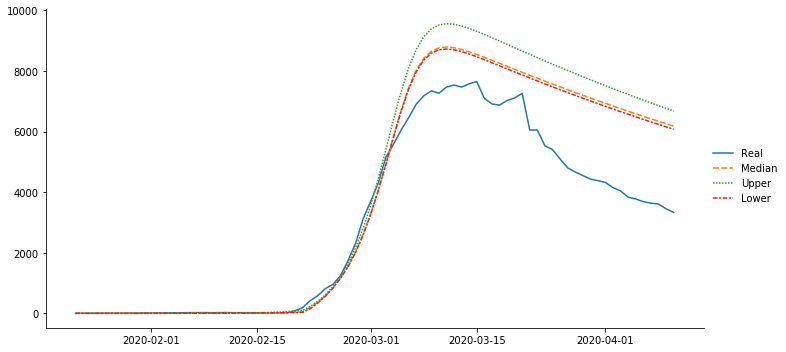

In [83]:
draw(I0, real=(confirmed-recovered)[country])

In [84]:
S.median(axis=1)[pd.to_datetime('2020-04-12')]

18918.141992311193

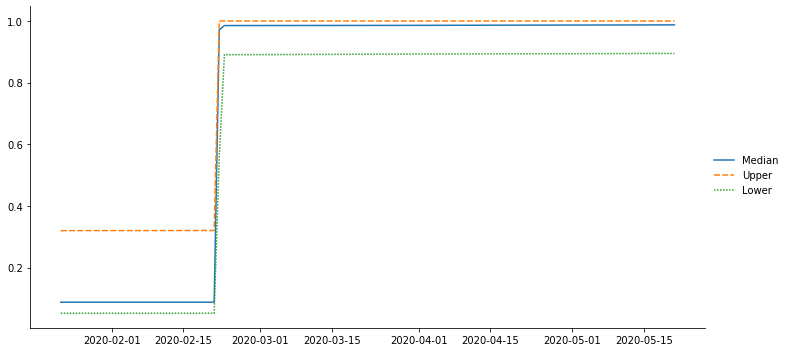

In [85]:
draw(q)

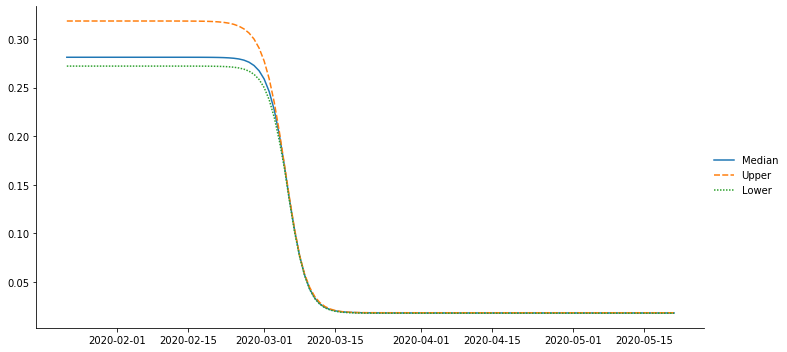

In [86]:
draw(b)

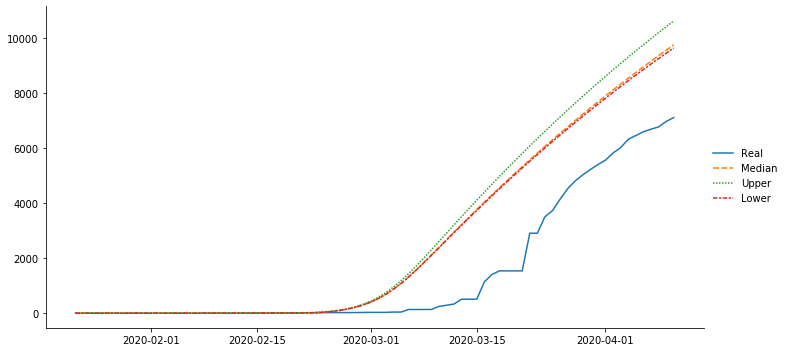

In [87]:
draw(R0, real=recovered[country])

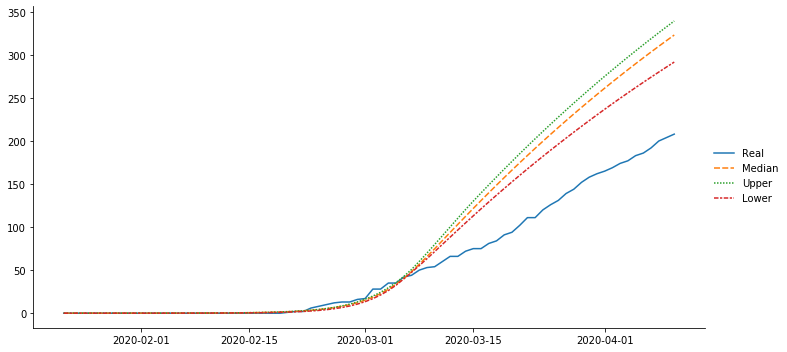

In [88]:
draw(D, real=death[country])

In [89]:
fit

Inference for Stan model: anon_model_101c6dab52da22ac0d9303c906e81fe1.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf_alpha  1.8e8   2.2e8  3.2e8   2.13   4.24   6.51  2.7e8  9.2e8      2   5.15
init_inf_beta   7.6e7   9.3e7  1.3e8   1.94    5.5 230.71  1.1e8  3.8e8      2   5.37
init_inf         0.94    0.62   0.88   0.01    0.3   0.66   1.62   2.46      2   54.8
b0_alpha       3955.3  4698.3 7213.2   2.65   8.15  91.27 3490.0  2.2e4      2    3.9
b0_beta         1.4e4   1.7e4  2.6e4   3.41  21.59 325.88  1.2e4  7.9e4      2    3.9
b0               0.31    0.05   0.07   0.25   0.27   0.28   0.36   0.43      2 178.06
b1_alpha         0.54    0.14   0.21    0.2   0.31   0.61   0.68   0.84      2   5.31
b1_beta         42.71   28.42  43.86  12.98  13.23  21.32  62.75 160.18      2   4.97
b1               0.02  1.9e-4 2.7e-

In [90]:
cumulative = pd.DataFrame(S.values, columns=range(len(S.columns)), index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=120+1, freq='D'))

In [91]:
predicted_recovered = pd.DataFrame(R.values, columns=range(len(R.columns)), index=pd.date_range(start=pd.to_datetime('2020-01-22'), periods=120+1, freq='D'))

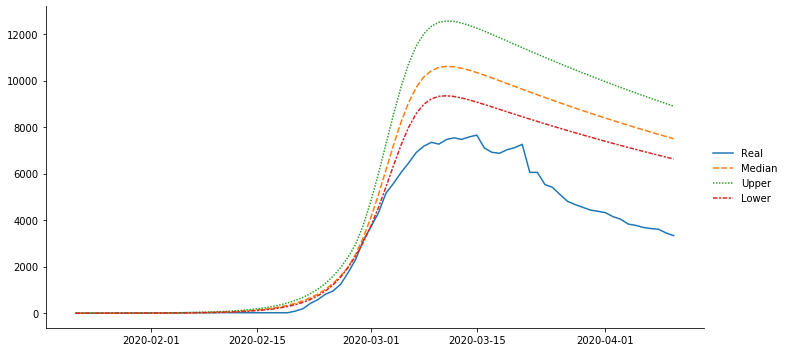

In [92]:
draw(cumulative - predicted_recovered, real=(confirmed-recovered)[country])

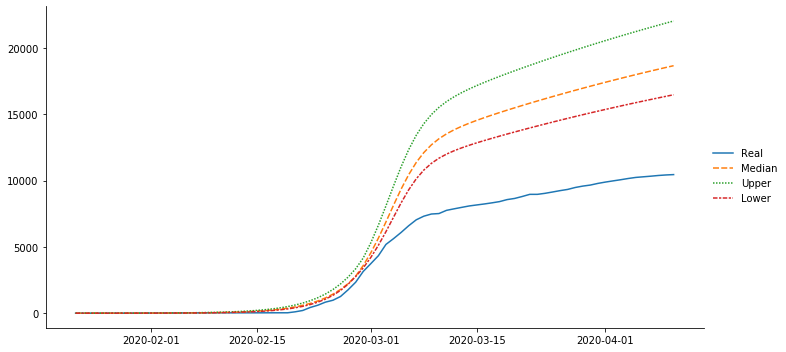

In [93]:
draw(cumulative, real=confirmed[country])

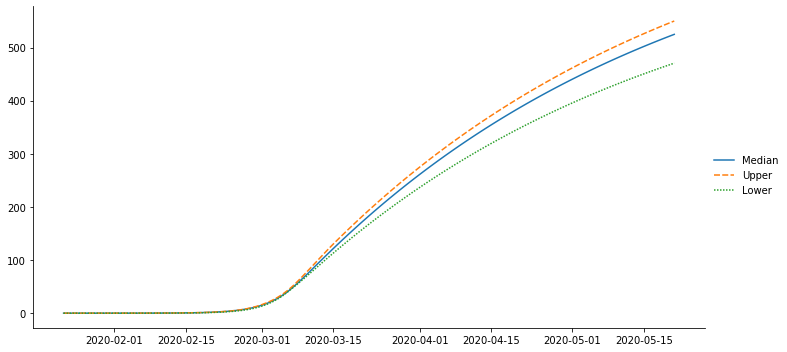

In [94]:
draw(D)